# Word Embeddings: Encoding Lexical Semantics

These notes are pulled from the PyTorch [tutorials on word embeddings](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html).

The gist of it is that we want to encode a sparse vector of words in a vocabulary into a dense vector representing the similarity between words in N-dimensional space.

Word embeddings are a representation of the semantics of a word, efficiently encoding semantic information that might be relevant to the task at hand.

## Word Embeddings in PyTorch

First we need to build up a vocabulary - a mapping between integer values of words and the words themselves. The embeddings are stored as a $|V|*D$ matrix, where $D$ is the dimensionality of the embeddings. A word in the vocabulary with index $i$ has its embedding stored at the $i$th row of the embedding matrix.

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
word_to_idx = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # A 2x5 word embedding matrix. 2 words in vocab, 5-dimensional embeddings
lookup_tensor = torch.tensor([word_to_idx["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]])


## N-Gram Language Modeling

Given a sequence of words $w$, we want to compute

$P(w_i|w_{i-1}, w_{i-2}, ... , w_{i-n+1})$

Where $w_i$ is the $i$th word of the sequence. This language model is based entirely on priors and not on contextual information after the target word.

In [3]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# Shakespeare's Sonnet 2
test_sentence = """
When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.
""".split()

# We build a list of tuples with two prior words for each word
# ([ word_i-2, word_i-1], target_word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
           for i in range(len(test_sentence) - 2)]
# Print the first 3
print(trigrams[:3])

vocab = set(test_sentence)
word_to_idx = {word: i for i, word in enumerate(vocab)}

class NGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    
losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the embedding model
for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:
        # Prepare the inputs to be passed to the model by wrapping them in tensors after
        # converting them to integers by looking them up in the dict
        context_idxs = torch.tensor([word_to_idx[w] for w in context], dtype=torch.long)
        
        # Zero the gradients
        model.zero_grad()
        
        # Run the forward pass
        log_probs = model(context_idxs)
        
        # Compute loss
        loss = loss_function(log_probs, torch.tensor([word_to_idx[target]], dtype=torch.long))
        
        # Backprop and update gradients
        loss.backward()
        optimizer.step()
        
        # Update loss
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
[522.0236539840698, 519.4884276390076, 516.9732069969177, 514.4773879051208, 511.99951362609863, 509.53822588920593, 507.0931746959686, 504.6624233722687, 502.24437713623047, 499.83915758132935]


## Computing Word Embeddings: Continuous Bag-of-Words

From the PyTorch tutorial:

> The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep learning. It is a model that tries to predict words given the context of a few words before and a few words after the target word. This is distinct from language modeling, since CBOW is not sequential and does not have to be probabilistic. Typcially, CBOW is used to quickly train word embeddings, and these embeddings are used to initialize the embeddings of some more complicated model. Usually, this is referred to as pretraining embeddings. It almost always helps performance a couple of percent.

The CBOW model uses a sliding window around a target word, so if we have a window of size 2, we'd get the words

<center>[$w_{i-2}, w_{i-1}, w_i, w_{i+1}, w_{i+2}$]</center>

We try to minimize

<center>$-\log p(w_i|C) = -\log \text{Softmax}(A(\displaystyle\sum_{w\in C} q_w)+b)$</center>

where $q_w$ is the embedding for a word $w$.

In [4]:
CONTEXT_SIZE = 2  # Context to left and right
EMBEDDING_DIM = 128
raw_text = """
We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.
""".split()

# Remove duplicates from the input text
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = [raw_text[i - j] for j in range(CONTEXT_SIZE, 0, -1)] + \
            [raw_text[i + j] for j in range(1, CONTEXT_SIZE + 1)]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])


class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, inputs):
        embeddings = self.embeddings(inputs).view((-1, self.context_size * self.embedding_dim))
        out = F.relu(self.linear1(embeddings))
        out = self.linear2(out)
        logprob = F.log_softmax(out, dim=1)
        return logprob
    
    def get_embeddings(self):
        return self.embeddings.weight
        

def make_context_vector(context, word_to_idx):
    idxs = [word_to_idx[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

make_context_vector(data[0][0], word_to_idx)

losses = []
loss_fn = nn.NLLLoss()    # Negative log-likelihood loss
model = CBOW(vocab_size, EMBEDDING_DIM, 2 * CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(50):
    total_loss = 0.0
    for context, target in data:
        context_idxs = make_context_vector(context, word_to_idx)
        model.zero_grad()
        logprob = model(context_idxs)
        loss = loss_fn(logprob, torch.tensor([word_to_idx[target]], dtype=torch.long))
        # Backprop
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    losses.append(total_loss)
    print("Epoch {0}: loss = {1}".format(epoch, total_loss))

embeddings = model.get_embeddings()
print("Embeddings: {}".format(embeddings.size()))

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]
Epoch 0: loss = 228.42594122886658
Epoch 1: loss = 176.64786863327026
Epoch 2: loss = 129.75249868631363
Epoch 3: loss = 85.45412310957909
Epoch 4: loss = 48.56786324083805
Epoch 5: loss = 24.920565873384476
Epoch 6: loss = 13.618402808904648
Epoch 7: loss = 8.675661906599998
Epoch 8: loss = 6.227013733237982
Epoch 9: loss = 4.8060721307992935
Epoch 10: loss = 3.8951507341116667
Epoch 11: loss = 3.261558823287487
Epoch 12: loss = 2.797846030443907
Epoch 13: loss = 2.44514284376055
Epoch 14: loss = 2.1675586691126227
Epoch 15: loss = 1.9444902101531625
Epoch 16: loss = 1.7616115296259522
Epoch 17: loss = 1.6081420117989182
Epoch 18: loss = 1.4783792784437537
Epoch 19: loss = 1.367209748364985
Epoch 20: loss = 1.2708677062764764
Epoch 21: loss = 1.1865016790106893
Epoch 22: loss = 1.11

Now let's try to visualize the embeddings with a plot of t-Distributed Stochastic Neighbor Embeddings (t-SNE) of the word embeddings matrix:

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings.detach().numpy())

print(tsne_results.shape)

[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.000s...
[t-SNE] Computed neighbors for 49 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 4.334593
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.540039
[t-SNE] Error after 300 iterations: 0.940162
(49, 2)


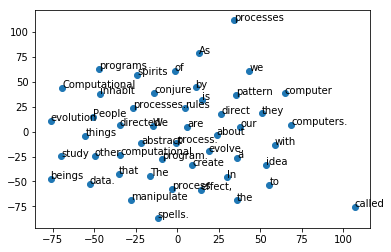

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(tsne_results[:, 0], tsne_results[:, 1])

for idx, word in idx_to_word.items():
    ax.annotate(word, (tsne_results[idx, 0], tsne_results[idx, 1]))

*Is this even good?*